# SPOT Kriging in 100 Dimensions: Nyström Approximation vs. Exact (Ackley Function)

This notebook demonstrates how to use the `Spot` class from `spotpython` with and without the Nyström approximation for Kriging surrogates on the 100-dimensional Ackley function.

We use a maximum of 500 function evaluations.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from spotpython.fun.objectivefunctions import Analytical
from spotpython.spot import Spot
from spotpython.utils.init import fun_control_init, design_control_init, surrogate_control_init

Seed set to 123


## Define the 100D Ackley Function

In [2]:
# do not change, these are given by the organizers
dim = 100
lower = np.full(dim, -32.768)
upper = np.full(dim, 32.768)
fun = Analytical().fun_ackley
fun_evals = 500
max_time =  600

## Set up SPOT Controls

## Regression and y as Infill Criterion

In [3]:
init_size = dim
use_nystrom = False
method = "regression"
infill_criterion = "y"
tolerance_x = 1e-9
seed = 321
max_surrogate_points = fun_evals
min_Lambda = -4
max_Lambda = 3
min_theta = -3
max_theta = 2
isotropic = False
kernel = "matern"
kernel_params = {"nu": 1.5}
selection_method = "distance"
min_success_rate = 0.2
max_time = 600

In [4]:
fun_control = fun_control_init(
    lower=lower,
    upper=upper,
    fun_evals=fun_evals,
    seed=seed,
    show_progress=True,
    infill_criterion=infill_criterion,
    tolerance_x=tolerance_x,
    TENSORBOARD_CLEAN=True,
    tensorboard_log=True,
    kernel=kernel,
    kernel_params=kernel_params,
    selection_method=selection_method,
    min_success_rate=min_success_rate,
    max_time=max_time
)
design_control = design_control_init(init_size=init_size)
surrogate_control_exact = surrogate_control_init(use_nystrom=use_nystrom, method=method, max_surrogate_points=max_surrogate_points, min_Lambda=min_Lambda, max_Lambda=max_Lambda, min_theta=min_theta, max_theta=max_theta, isotropic=isotropic)

Seed set to 321


Moving TENSORBOARD_PATH: runs/ to TENSORBOARD_PATH_OLD: runs_OLD/runs_2025_11_05_00_11_14_0
Created spot_tensorboard_path: runs/spot_logs/000_maans14_2025-11-05_00-11-14 for SummaryWriter()


# Sklearn Gaussian Process Regressor as Surrogate

In [5]:
from sklearn.gaussian_process import GaussianProcessRegressor
# from sklearn.gaussian_process.kernels import Matern, ConstantKernel

# # Use Matern kernel instead of RBF
# kernel = ConstantKernel(1.0, (1e-2, 1e12)) * Matern(length_scale=1.0, length_scale_bounds=(1e-4, 1e2), nu=2.5)
# S_GP = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100)


from sklearn.gaussian_process.kernels import WhiteKernel

import numpy as np
from sklearn.gaussian_process.kernels import ConstantKernel, Matern

# D = 100 (number of dimensions)
D = 100

# 1. Initialize length_scale as a vector of length D.
#    A simple starting point is a vector of ones.
#    (Section V provides a much more robust initialization strategy).
initial_length_scales = np.ones(D) 

# 2. Define the bounds for EACH of the 100 length_scales.
#    Tighter, more practical bounds are recommended.
#    (See Section V for a deep dive on bounds).
length_scale_bounds = (1e-3, 1e3) 

# 3. Create the core Matern ARD kernel
kernel_matern_ard = Matern(
    length_scale=initial_length_scales, 
    length_scale_bounds=length_scale_bounds, 
    nu=2.5  # User's choice; this is a good, robust default.
)

# 4. Create the signal variance kernel.
#    The user's upper bound of 1e12 is far too large and
#    can cause numerical instability. A tighter bound is better.
kernel_const = ConstantKernel(
    1.0, 
    (1e-3, 1e3) 
)

# 5. Combine them (this kernel is still incomplete; see Section III)
kernel_ard = kernel_const * kernel_matern_ard

# (Using kernel_const and kernel_matern_ard from Section II)

# 1. Define the noise kernel
kernel_noise = WhiteKernel(
    noise_level=1.0,  # Initial guess (e.g., 1.0), will be optimized
    noise_level_bounds=(1e-5, 1e1) # Bounds for the noise variance
)

# 2. The complete, correct kernel structure
#    (Signal Variance * Correlation) + Observation Noise
kernel_complete = (kernel_const * kernel_matern_ard) + kernel_noise

# 3. The final GPR model
S_GP = GaussianProcessRegressor(
    kernel=kernel_complete,
    n_restarts_optimizer=100  # User's value
)


spot_exact_sk = Spot(
    fun=fun,
    fun_control=fun_control,
    design_control=design_control,
    surrogate_control=surrogate_control_exact,
    surrogate=S_GP,
)
spot_exact_sk.run()

spotpython tuning: 20.97476373848855 [##--------] 20.20%. Success rate: 100.00% 
spotpython tuning: 20.97476373848855 [##--------] 20.40%. Success rate: 50.00% 
spotpython tuning: 20.97476373848855 [##--------] 20.60%. Success rate: 33.33% 
spotpython tuning: 20.97476373848855 [##--------] 20.80%. Success rate: 25.00% 
spotpython tuning: 20.97476373848855 [##--------] 21.00%. Success rate: 20.00% 
spotpython tuning: 20.97476373848855 [##--------] 21.20%. Success rate: 16.67% 
spotpython tuning: 20.97476373848855 [##--------] 21.40%. Success rate: 14.29% 
spotpython tuning: 20.97476373848855 [##--------] 21.60%. Success rate: 12.50% 
spotpython tuning: 20.97476373848855 [##--------] 21.80%. Success rate: 11.11% 
spotpython tuning: 20.97476373848855 [##--------] 22.00%. Success rate: 10.00% 
spotpython tuning: 20.97476373848855 [##--------] 22.20%. Success rate: 9.09% 
spotpython tuning: 20.97476373848855 [##--------] 22.40%. Success rate: 8.33% 
spotpython tuning: 20.890175308608693 [##

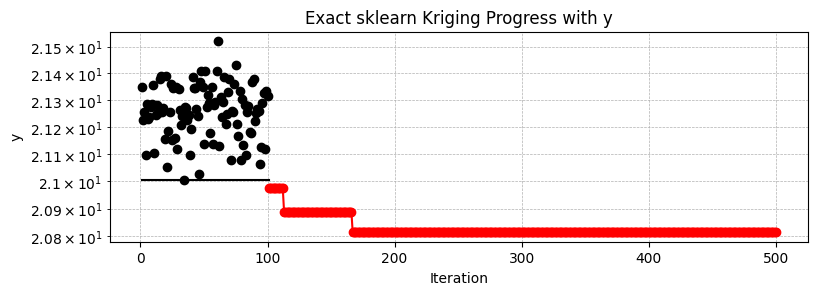

In [6]:
spot_exact_sk.plot_progress(log_y=True, title="Exact sklearn Kriging Progress with y")

In [7]:
print(f"[100D] Exact Kriging y: min y = {spot_exact_sk.min_y:.4f} at x = {spot_exact_sk.min_X}")


[100D] Exact Kriging y: min y = 20.8151 at x = [ 17.74952716   4.43945209 -22.84307099 -24.2567452  -28.31398966
  11.34280591  -4.058049    -7.27601601   4.76749755  18.72204879
   5.23205639 -16.73942266  30.8984803   -0.11134214   8.27898911
  -9.21590958 -13.70441953   8.0830632   -2.38258855  20.1924973
  26.15183577 -24.73320664   1.00437726  17.03951534 -11.68260379
 -14.50177886   3.25399092 -16.2322671  -30.30121109 -18.90794994
  -2.20514255  -2.02159221  -2.68708353 -26.96770226  13.23065934
   9.30433887  -2.83106128  27.95433368 -23.40037354 -26.76453861
 -16.97395296 -13.53638948  -9.78506856  12.86586838 -24.12837957
   2.68057728 -15.06901872   7.70677021 -22.98542362  14.9363556
 -11.13718442   5.15546939   8.95854076  14.24528647   6.40504258
 -27.28604826  10.39043521   9.89423466  27.25255053  -9.25936051
 -31.77505187  16.69303776  19.7626127  -11.2116729   -1.52703457
   4.52717616 -23.0757775  -17.23110675   7.10344619  -9.84981855
  -4.73091984 -17.09890662 -18.